In [636]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

In [763]:
df_train_modify = pd.read_csv('../../csv/train_modifie_mickael.csv')
df_test_modify = pd.read_csv('../../csv/test_modifie_mickael.csv')

df_train = df_train_modify.drop(['Unnamed: 0', 'count','HI'], axis=1)
df_test = df_test_modify.drop(['Unnamed: 0', 'count','HI'], axis=1)

# Il FAUT éliminer ce point de données sans quoi impossible d'encoder cette variable et de réaliser une cross-validation ou un grid search cv
df_train = df_train[df_train['weather'] != 4]

In [766]:
X_train = df_train.drop(['registered', 'casual'], axis=1)
y_train_registered = df_train['registered']
y_train_casual = df_train['casual']

X_test = df_test.drop(['registered', 'casual'], axis=1)
y_test_registered = df_test['registered']
y_test_casual = df_test['casual']

In [768]:
X_train, X_test, y_train_registered, y_test_registered = train_test_split(X_train, y_train_registered, test_size=0.2, random_state=33)
# X_train, X_test, y_train_casual, y_test_casual = train_test_split(X_train, y_train_casual, test_size=0.2)

# Preprocessing

In [794]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

def metrics_scores(y, y_pred):
    print('MSE test : ' + str(mean_squared_error(y, y_pred)))
    print('RMSE test : ' + str(np.sqrt(mean_squared_error(y, y_pred))))
    print('MAE test : ' + str(mean_absolute_error(y, y_pred)))
    print('MdAE test : ' + str(median_absolute_error(y, y_pred)))

def metrics_scores_train(y, y_pred):
    print('MSE train : ' + str(mean_squared_error(y, y_pred)))
    print('RMSE train : ' + str(np.sqrt(mean_squared_error(y, y_pred))))
    print('MAE train : ' + str(mean_absolute_error(y, y_pred)))
    print('MdAE testraint : ' + str(median_absolute_error(y, y_pred)))

In [805]:
#Features et pipelines
scaled_features = ['temp', 'atemp', 'windspeed', 'humidity', 'hours']# 'temp', 
scaled_pipeline = make_pipeline(StandardScaler())
encoded_features = ['season','weather', 'week_days', 'months']
encoded_pipeline = make_pipeline(OneHotEncoder())#

#preprocessing et main pipeline
preprocessor = make_column_transformer((scaled_pipeline, scaled_features),(encoded_pipeline, encoded_features), remainder="passthrough")
xgb = XGBRegressor(n_estimators=80, max_depth=6, subsample=0.8, learning_rate=0.2)#, max_depth=10, learning_rate=0.15
model = make_pipeline(preprocessor, xgb)

In [808]:
model.fit(X_train,y_train_registered)
y_pred = model.predict(X_train)

residus_train = y_pred-y_train_registered
residus_train = pd.DataFrame(residus_train)

metrics = ['r2','neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error','neg_median_absolute_error']
scores = cross_validate(model,X_train,y_train_registered,cv=5,scoring=metrics)
r2 = np.nanmean(scores['test_r2'])
print('r2 : ' + str(r2))
print('r2 adj. : ' + str(adjustedR2(r2,X_train.shape[0],X_train.shape[1])))
print('MSE : ' + str(np.nanmean(-scores['test_neg_mean_squared_error'])))
print('RMSE : ' + str(np.nanmean(-scores['test_neg_root_mean_squared_error'])))
print('MAE : ' + str(np.nanmean(-scores['test_neg_mean_absolute_error'])))
print('MdAE : ' + str(np.nanmean(-scores['test_neg_median_absolute_error'])))
print('------------------------------------------------')


# r2 = model.score(X_test, y_test_registered)

# print('r2 : ' + str(r2))
# print('r2 adj. : ' + str(adjustedR2(r2,X_train.shape[0],X_train.shape[1])))
# metrics_scores(y_test_registered,y_pred_registered)
# residus_test = y_pred-y_train_registered
# y_pred_registered = model.predict(X_test)

r2 : 0.8754316578165715
r2 adj. : 0.8752590776805457
MSE : 2467.4543006679396
RMSE : 49.64138814479058
MAE : 32.36353720884951
MdAE : 19.11341438293457
------------------------------------------------


In [ ]:
parameters = {'xgbregressor__n_estimators': np.arange(80,101,5),
              'xgbregressor__max_depth': np.arange(5,9,1),
              'xgbregressor__learning_rate':[0.1],
              'xgbregressor__subsample': np.arange(0.88,0.92,0.01),
              'xgbregressor__colsample_bytree': np.arange(0.4,0.6,0.1),
              'xgbregressor__colsample_bylevel': np.arange(0,1,0.5)}

grid = GridSearchCV(model, parameters,cv=2,error_score='raise')
grid.fit(X_train, y_train_registered)

In [ ]:
grid.best_params_

{'xgbregressor__colsample_bytree': 0.5,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 7,
 'xgbregressor__n_estimators': 90,
 'xgbregressor__subsample': 0.8999999999999999}

In [813]:
N, train_score, val_score = learning_curve(model, X_train, y_train_registered, train_sizes=np.linspace(0.1,1,20))

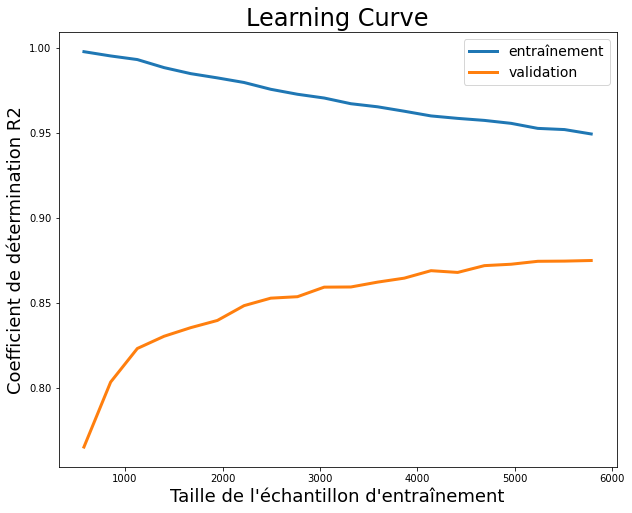

In [815]:
plt.figure(figsize=(10,8))
plt.plot(N,train_score.mean(axis=1),lw=3,label='entraînement')
plt.plot(N,np.nanmean(val_score,axis=1),lw=3,label='validation')
plt.title('Learning Curve',fontsize=24)
plt.xlabel('Taille de l\'échantillon d\'entraînement',fontsize=18)
plt.ylabel('Coefficient de détermination R2',fontsize=18)
plt.legend(fontsize=14)

Text(0, 0.5, 'y_train_registered - y-pred')

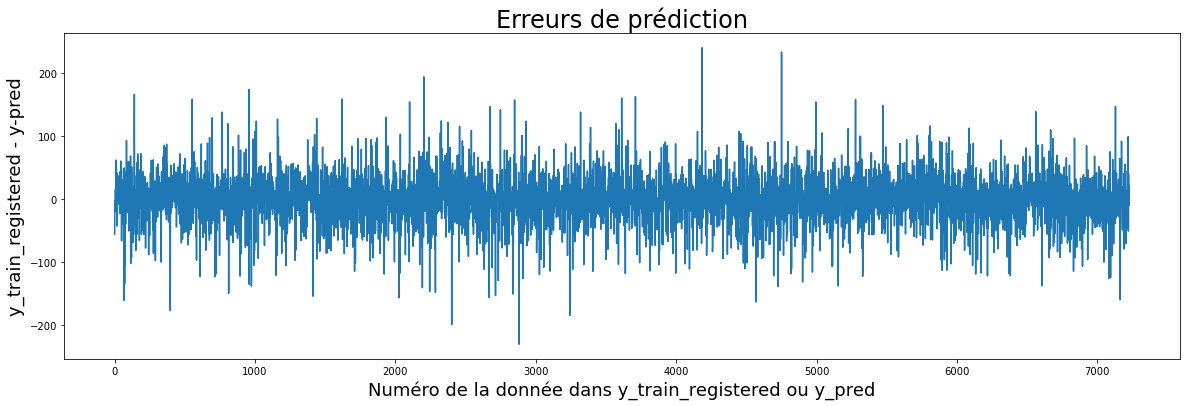

In [ ]:
plt.figure(figsize=(20,6))
interval = y_pred.shape[0]
x = np.arange(interval)
plt.plot(x, residus_train)
plt.title('Erreurs de prédiction', fontdict={'fontsize':24})
plt.xlabel('Numéro de la donnée dans y_train_registered ou y_pred',fontsize=18)
plt.ylabel('y_train_registered - y-pred',fontsize=18)

In [ ]:
outliers_indice = np.sort(residus_train.loc[(residus_train['registered'] > 100) | (residus_train['registered'] < -100),:].index)

In [ ]:
pd.set_option('display.max_rows', 80)
outliers = df_train.loc[outliers_indice]
df_train_no_outliers = df_train.drop(outliers_indice)

<AxesSubplot:xlabel='atemp', ylabel='temp'>

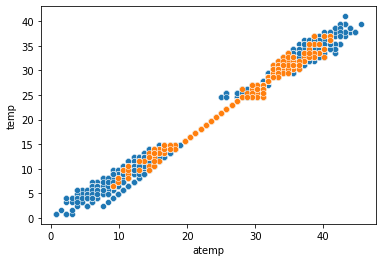

In [ ]:
sns.scatterplot(x='atemp', y='temp', data=df_train_no_outliers)
sns.scatterplot(x='atemp', y='temp', data=outliers)

Text(0.5, 0, 'y_train_registered - y_pred')

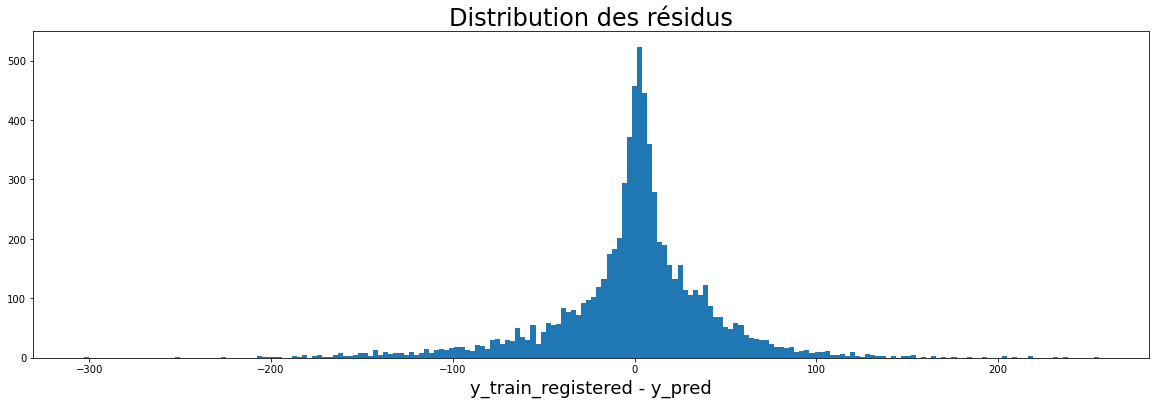

In [ ]:
plt.figure(figsize=(20,6))
plt.hist(residus_train,bins=200)
plt.title('Distribution des résidus', fontdict={'fontsize':24})
plt.xlabel('y_train_registered - y_pred',fontsize=18)